# Praca domowa 2
#### Ilona Bednarz

## Odtworzenie modelu z PD1

### Zmienna objaśniana:
S1 - Are you married?

### Wybrane zmienne objaśniające:

#### numeryczne:

* Q16: How many of your relatives do you see in person at least once a month?  - numeryczna

* pphhsize: Household Size

#### binarne:

* hcm2017q24_church: met in or through church or religious organization

* w6_otherdate_all: In past yr have you met anyone for dating romance or sex (not incl current partner)

### Zbudowany model:
RandomForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

df = pd.read_stata('dane/HCMST_2017.dta')

# wybor zmiennych
X = df[['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']].copy()
y = df['S1'].copy()

# przygotowanie danych
X['w6_otherdate_all'] = X['w6_otherdate_all'].replace('Refused', np.nan)

y = y[np.sum(X.isna(), axis=1) == 0]
X = X.dropna(axis=0).reset_index(drop=True)

bin_columns = ["hcm2017q24_church", "w6_otherdate_all"]
dummies = pd.get_dummies(X[bin_columns]).iloc[:, [1, 4]]
dummies.columns = bin_columns
X[bin_columns] = dummies

y = pd.get_dummies(y).iloc[:, 0].reset_index(drop=True) # 1 == married

# dopasowanie modelu
clf = RandomForestClassifier(n_jobs=4, n_estimators= 30, random_state=123)
clf.fit(X, y)

print("Istotność zmiennych:\n", dict(zip(X.columns, clf.feature_importances_)))

Istotność zmiennych:
 {'Q16': 0.3375466027253457, 'pphhsize': 0.3910790882836039, 'hcm2017q24_church': 0.042898728951211766, 'w6_otherdate_all': 0.22847558003983867}


## Profile Ceteris Paribus i Partial Dependence Plots

Osoba wybrana do narysowania profili CP: 
Q16                  12
pphhsize              2
hcm2017q24_church     0
w6_otherdate_all      1
Name: 1612, dtype: object


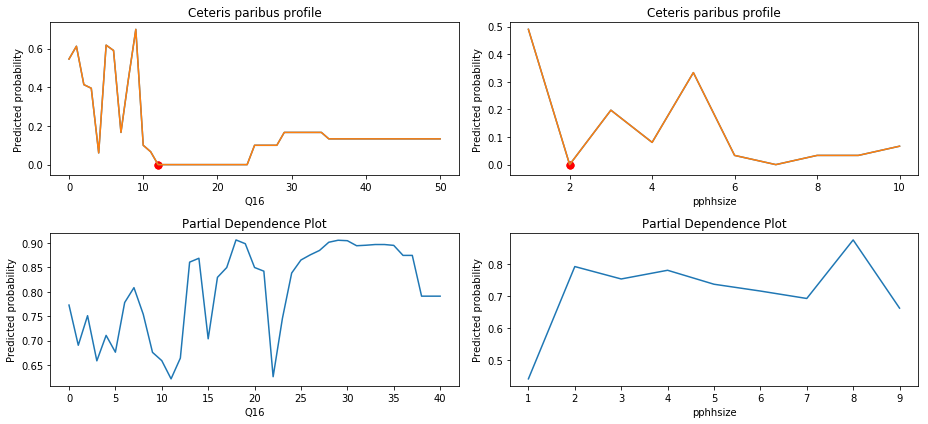

In [3]:
def cp_profile(var, obs, X, mod):
    """Generuj rysunek profilu ceteris paribus dla zmiennej var, obserwacji obs"""
    values = np.arange(min(X[var]),max(X[var])+1)
    row = X.iloc[obs,:].copy()
    cp = []
    for z in values:
        row[var] = z
        cp.append(clf.predict_proba([row])[0][1])
    sns.lineplot(x=values, y=cp)
    plt.scatter(X.iloc[obs, :][var], clf.predict_proba([X.iloc[obs,:]])[0][1], c='red', s=50)
    plt.xlabel(var)
    plt.ylabel('Predicted probability')
    plt.title('Ceteris paribus profile')
    
def pdp_plot(var, X, mod):
    """Generuj wykres PDP dla zmiennej var"""
    values = np.arange(min(X[var]),max(X[var])+1)
    cps = []
    for obs in range(X.shape[0]):
        row = X.iloc[obs,:].copy()
        cp = []
        for z in values:
            row[var] = z
            cp.append(clf.predict_proba([row])[0][1])
        cps.append(cp)
    cps_mean = np.mean(cps, axis=0)
    sns.lineplot(x=values, y=cps_mean)
    plt.xlabel(var)
    plt.ylabel('Predicted probability')
    plt.title('Partial Dependence Plot')
    
print("Osoba wybrana do narysowania profili CP: ")
osoba = 1612
print(X.iloc[osoba, :])

matplotlib.rcParams['figure.figsize'] = [13, 6]
plt.subplot(2, 2, 1)
cp_profile('Q16', osoba, X, clf)
plt.subplot(2, 2, 2)
cp_profile('pphhsize', osoba, X, clf)
plt.subplot(2, 2, 3)
pdp_plot('Q16', X, clf)
plt.subplot(2, 2, 4)
pdp_plot('pphhsize', X, clf)

plt.tight_layout()
plt.show()

Osoba wybrana do profili Ceteris Paribus spotkała 12 osob ze swojej rodziny przez ostatni miesiąc (zmienna Q16=12), mieszka w dwuosobowym gospodarstwie domowym (zmienna pphhsize=2), nie poznała swojego obecnego partnera na spotkaniu religijnym oraz w ciągu ostatniego roku była na randce z kimś innym niż obecny partner.

Na obu wykresach Ceteris Paribus występują silne oscylacje, co świadczy o niestabilności modelu.


**Zmienna Q16:**

Wykres Ceteris Paribus prezentuje całkowicie inną zależność zmiennej celu od zmiennej Q16 niż prezentuje odpowiadający mu wykres PDP. Prawdopodobnie istnieją korelacje między tą zmienną a jakąć inną, przez co oba wykresy mogą być niemiarodajne - niespełnione jest ich założenie. Wykres PDP przedstawia dużo mniejsze oscylacje niż CP - wartości zmiennej celu wahają się pomiędzy 0.65 a 0.9 (skala osi y jest różna, więc oscylacje mogą wydawać się większe). Można się dopatrzyć delikatnej dodatniej zależności między zmienną celu a Q16. Można ją tłumaczyć tak, że osoby często spotykające się z członkami rodziny (wysoka wartość Q16), są ogólnie bardziej 'rodzinne', a zatem bardziej skłonne do zawierania małżeństwa i zakładania własnej rodziny.

**Zmienna pphhsize:**

Podobnie jak wcześniej, CP przedstawia całkowicie inną zależność zmiennej celu od zmiennej pphhsize niż prezentuje wykres PDP, a więc musimy być ostrożni w wyciąganiu wniosków na ich podstawie. Można zauważyć, że dla wartości pphhsize=1, która oznacza, że osoba mieszka sama, na wykresie PDP prawdopodobieństwo posiadania małżonka jest znacznie niższe niż dla pozostałych wartości. Lecz i tak jest ono dalekie od 0, co byłoby zgodne z intuicją. Dla pozostałych wartości wykres jest mniej więcej stały, więc być może dobrym pomysłem byłoby zastąpienie tej zmiennej zmienną binarną 'czy osoba mieszka sama'.

Podsumowując, obie wybrane zmienne wydają się mieć niewielki wpływ na wartość zmiennej celu, z wyjątkiem przypadku, gdy pphhsize=1.